In [1]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
from torchvision import models
from torch import nn, optim, cuda
from torchvision.transforms import transforms
to_tensor = transforms.ToTensor()

In [11]:
def add_coords_to_img(img_arr: np.array, coords: np.array) -> Image:
    layers_map = {
        1: 'L',
        3: 'RGB',
        4: 'RGBA'
    }
    layer_count = img_arr.shape[2] if len(img_arr.shape) == 3 else 1
    image = Image.fromarray(img_arr.astype('uint8'), layers_map[layer_count])
    draw = ImageDraw.Draw(image)
    for point in coords:
        px = point.item(0)
        py = point.item(1)
        d = img_arr.shape[0] * 0.015
        draw.ellipse((px - d, py - d, px + d, py + d), fill="red")
    return image

In [3]:
MODEL_PATH = './data/weights/resnet50_regression_v2.2.3.pt'
NUM_CLASSES = 8

In [4]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

model.load_state_dict(torch.load(MODEL_PATH))
model.eval();

In [15]:
img = Image.open(f"data/trainset_128/{0:0>7}.png")
tensor = to_tensor(img).unsqueeze(0)

In [16]:
tensor.shape

torch.Size([1, 3, 128, 128])

In [17]:
%%time
predict_coords = model(tensor)
predict_coords = torch.split(predict_coords, 1, dim=1)
predict_coords = np.resize(predict_coords, (4,2))

CPU times: user 163 ms, sys: 5.08 ms, total: 168 ms
Wall time: 85.6 ms


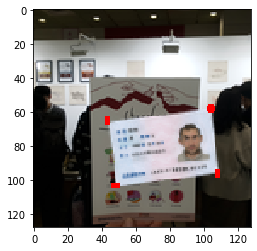

In [18]:
plt.imshow(add_coords_to_img(np.array(img), predict_coords));

# make pipeline

In [19]:
def load_model(weights_path: str = None):
    NUM_CLASSES = 8
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

    MODEL_PATH = './data/weights/resnet50_regression_v2.2.3.pt'
    path = weights_path if weights_path else MODEL_PATH
    model.load_state_dict(torch.load(path))
    model.eval()
    
    return model

def predict_coords(model, tensor):
    predict_coords = model(tensor)
    predict_coords = torch.split(predict_coords, 1, dim=1)
    predict_coords = np.resize(predict_coords, (4,2))
    return predict_coords

def get_card_coords(img: Image) -> np.array:
    model = load_model()
    tensor = to_tensor(img).unsqueeze(0)
    return predict_coords(model, tensor)

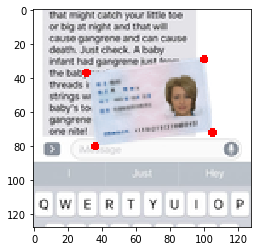

In [20]:
some_img = Image.open(f"data/trainset_128/{5:0>7}.png")
plt.imshow(add_coords_to_img(np.array(some_img), get_card_coords(some_img)));